# Separate the time series into orbit #

Read in the satellite databases and separate each time stamp into nominal orbits.

Orbit will be defined by latitude (or dipole latitude) as this is the variable we want to eventually want to match in order to investigate orbit by orbit changes of neutral density. 

In [48]:
#plot matplotlib figures in the notebook
%matplotlib inline

#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import scipy.signal as sig
# import plotting
import matplotlib.pyplot as plt

sat = 'A'
sat_f = f'D:\\data\\SatDensities\\satdrag_database_grace_{sat}.hdf5'
# orbital period
sat_p = 90
# peak column
pk_col = 'SatLat'

columns = ['DateTime','SatLat', 'SatLon', 'SatHeight', 
           'SatLT', 'SatDipoleLat', 'SatMagLon',
           'SatMagLT', 'SatDensity', '400kmDensity', '410kmDensity',
           'storm', 'storm phase']
columns = ['DateTime','SatLat', 'SatDipoleLat',
           'SatLT', 'SatMagLon',
           'SatMagLT', 'SatDensity', '400kmDensity', 
           'storm', 'storm phase']


In [49]:
# read in data
sat_df = pd.read_hdf(sat_f)
# nominal resolution of data set
res = sat_df['DateTime'].diff().mean()
# number of points between orbits
sat_pts = sat_p*60./res.seconds

sat_df = sat_df[columns]
sat_df.columns

Index(['DateTime', 'SatLat', 'SatDipoleLat', 'SatLT', 'SatMagLon', 'SatMagLT',
       'SatDensity', '400kmDensity', 'storm', 'storm phase'],
      dtype='object')

In [50]:
sat_df[pk_col].diff().abs().mean()
sat_df[pk_col].diff().abs().median()
lat_res= 9

18.097464637390207

18.54663

In [51]:
# find peaks
pk1, _ = sig.find_peaks(sat_df[pk_col],distance=sat_pts-2)
pk2, _ = sig.find_peaks(-1*sat_df[pk_col],distance=sat_pts-2)

if pk1.min() < pk2.min():
    pk_a = pk1
    pk_b = pk2
else:
    pk_a = pk2
    pk_b = pk1

In [52]:
pk1.max()
pk2.max()
min([pk_b.size,pk_a.size])


1043135

1043126

50782

(12053.0, 12054.0)

<Axes: xlabel='DateTime'>

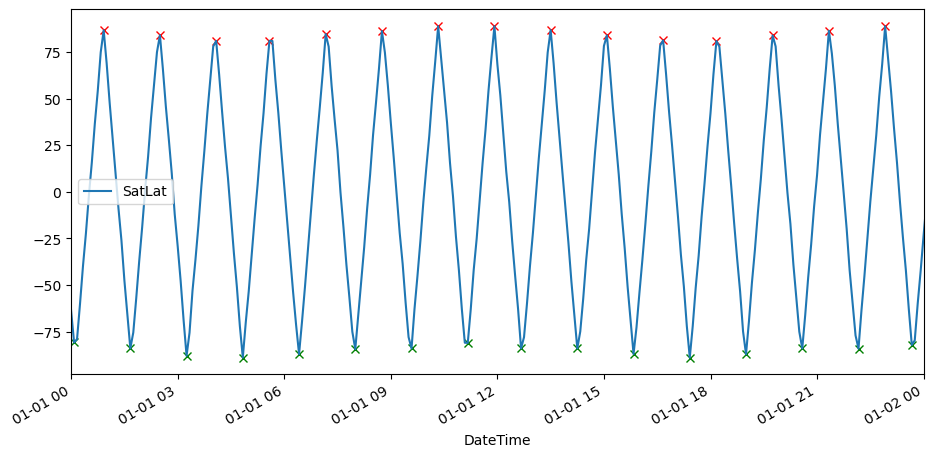

In [53]:
fig, ax = plt.subplots(1,1, figsize=(11,5),gridspec_kw={'bottom':0.15})

ax.plot(sat_df.loc[pk1,'DateTime'],sat_df.loc[pk1,'SatLat'], "xr")
ax.plot(sat_df.loc[pk2,'DateTime'],sat_df.loc[pk2,'SatLat'], "xg")
ax.set_xlim(pd.to_datetime('2003-01-01'),pd.to_datetime('2003-01-02'))
sat_df.plot('DateTime','SatLat', xlim=['2003-01-01','2003-01-02'],ax=ax)

plt.show()

In [54]:
database = []

for i in np.arange(min([pk_b.size,pk_a.size])-1):
    orb_a0 = (sat_df['DateTime'] >= sat_df.loc[pk_a[i],'DateTime']) & (sat_df['DateTime'] < sat_df.loc[pk_b[i],'DateTime'])
    orb_a1 = (sat_df['DateTime'] >= sat_df.loc[pk_a[i+1],'DateTime']) & (sat_df['DateTime'] < sat_df.loc[pk_b[i+1],'DateTime'])

    orb_b0 = (sat_df['DateTime'] >= sat_df.loc[pk_b[i],'DateTime']) & (sat_df['DateTime'] < sat_df.loc[pk_a[i+1],'DateTime'])
    orb_b1 = (sat_df['DateTime'] >= sat_df.loc[pk_b[i+1],'DateTime']) & (sat_df['DateTime'] < sat_df.loc[pk_a[i+2],'DateTime'])

    df_a0 = sat_df[orb_a0].copy()
    df_a0 = df_a0.sort_values(by=pk_col)
    df_a0['SatLat_x'] = df_a0['SatLat']

    df_a1 = sat_df[orb_a1].copy()
    df_a1 = df_a1.sort_values(by=pk_col)

    db_a = pd.merge_asof(left=df_a0.dropna(),right=df_a1.dropna(),on=pk_col,direction='nearest',tolerance=lat_res)
    #db_a['den_diff'] = db_a['400kmDensity_x'] - db_a['400kmDensity_y'] 

    df_b0 = sat_df[orb_b0].copy()
    df_b0 = df_b0.sort_values(by=pk_col)
    df_b0['SatLat_x'] = df_b0['SatLat']

    df_b1 = sat_df[orb_b1].copy()
    df_b1 = df_b1.sort_values(by=pk_col)

    db_b = pd.merge_asof(left=df_b0.dropna(),right=df_b1.dropna(),on=pk_col,direction='nearest',tolerance=lat_res)
    #db_b['den_diff'] = db_b['400kmDensity_x'] - db_b['400kmDensity_y'] 

    database.append(db_a)
    database.append(db_b)

    if i % 2000 == 0:
        print(f'Itteration: {i}, %={100*i/(pk_a.size-3)}')


Itteration: 0, %=0.0
Itteration: 2000, %=3.9385584875935407
Itteration: 4000, %=7.877116975187081
Itteration: 6000, %=11.815675462780622
Itteration: 8000, %=15.754233950374163
Itteration: 10000, %=19.692792437967704
Itteration: 12000, %=23.631350925561243
Itteration: 14000, %=27.569909413154786
Itteration: 16000, %=31.508467900748325
Itteration: 18000, %=35.44702638834187
Itteration: 20000, %=39.38558487593541
Itteration: 22000, %=43.32414336352895
Itteration: 24000, %=47.262701851122486
Itteration: 26000, %=51.20126033871603
Itteration: 28000, %=55.13981882630957
Itteration: 30000, %=59.07837731390311
Itteration: 32000, %=63.01693580149665
Itteration: 34000, %=66.9554942890902
Itteration: 36000, %=70.89405277668374
Itteration: 38000, %=74.83261126427728
Itteration: 40000, %=78.77116975187081
Itteration: 42000, %=82.70972823946435
Itteration: 44000, %=86.6482867270579
Itteration: 46000, %=90.58684521465143
Itteration: 48000, %=94.52540370224497
Itteration: 50000, %=98.46396218983853


In [55]:
db_df = pd.concat(database, ignore_index=True)

In [56]:
db_df['den_diff'] = db_df['400kmDensity_x']-db_df['400kmDensity_y']
db_df.columns

Index(['DateTime_x', 'SatLat', 'SatDipoleLat_x', 'SatLT_x', 'SatMagLon_x',
       'SatMagLT_x', 'SatDensity_x', '400kmDensity_x', 'storm_x',
       'storm phase_x', 'SatLat_x', 'DateTime_y', 'SatDipoleLat_y', 'SatLT_y',
       'SatMagLon_y', 'SatMagLT_y', 'SatDensity_y', '400kmDensity_y',
       'storm_y', 'storm phase_y', 'den_diff'],
      dtype='object')

In [57]:
db_df.shape
sat_df.shape

(9024381, 21)

(1043137, 10)

In [58]:
db_df.to_hdf(f'D:\\data\\SatDensities\\density_diff_database_grace_{sat}.hdf5',
                key='database', mode='w', format='fixed', complevel=9)